In [186]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
import random

In [187]:
class LayerUtil:
    def __init__(self):
        pass
    
    def conv(self, in_channels, filters, kernel_size):
        return nn.Conv2d(in_channels = in_channels, out_channels = filters, kernel_size = kernel_size)
    
    def pool(self, kernel_size = (2,2), stride = 2):
        return nn.MaxPool2d(kernel_size = kernel_size, stride = stride)
    
    def deconv(self, in_channels, filters, kernel_size, stride = 2):
            return nn.ConvTranspose2d(in_channels = in_channels, out_channels = filters, kernel_size = kernel_size, stride = 2)
        
    def crop_and_copy(self, encoder_tensor, decoder_tensor):
        encoder_tensor_width = np.squeeze(np.asarray(encoder_tensor[0].shape[1]))
        encoder_tensor_height = np.squeeze(np.asarray(encoder_tensor[0].shape[2]))
        decoder_tensor_width = np.squeeze(np.asarray(decoder_tensor[0].shape[1]))
        decoder_tensor_height = np.squeeze(np.asarray(decoder_tensor[0].shape[2]))
        decoder_tensor_channels = np.squeeze(np.asarray(decoder_tensor[0].shape[0]))
        crop_width = (encoder_tensor_width - decoder_tensor_width) // 2
        crop_height = (encoder_tensor_height - decoder_tensor_height) // 2
        reshaped_encoder = torch.rand(12, decoder_tensor_channels, decoder_tensor_width, decoder_tensor_height)
        
        for i in range(12):
            reshaped_encoder[i] = encoder_tensor[i][:, crop_width:encoder_tensor_width - crop_width, 
                                                    crop_height:encoder_tensor_height - crop_height]
        output = torch.cat((reshaped_encoder, decoder_tensor), 1)
        return output

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.helper = LayerUtil()
        self.conv1_1 = self.helper.conv(3, 64, (3,3))
        self.conv1_2 = self.helper.conv(64, 64, (3,3))
        self.pool1 = self.helper.pool((2,2), 2)
        
        self.conv2_1 = self.helper.conv(64, 128, (3,3))
        self.conv2_2 = self.helper.conv(128, 128, (3,3))
        self.pool2 = self.helper.pool((2,2), 2)
        
        self.conv3_1 = self.helper.conv(128, 256, (3,3))
        self.conv3_2 = self.helper.conv(256, 256, (3,3))
        self.pool3 = self.helper.pool((2,2), 2)
        
        self.conv4_1 = self.helper.conv(256, 512, (3,3))
        self.conv4_2 = self.helper.conv(512, 512, (3,3))
        self.pool4 = self.helper.pool((2,2), 2)
        
        self.conv5_1 = self.helper.conv(512, 1024, (3,3))
        self.conv5_2 = self.helper.conv(1024, 1024, (3,3))
        self.deconv1 = self.helper.deconv(1024, 512, (2,2))
        
        self.conv6_1 = self.helper.conv(1024, 512, (3,3))
        self.conv6_2 = self.helper.conv(512, 512, (3,3))
        self.deconv2 = self.helper.deconv(512, 256, (2,2))
        
        self.conv7_1 = self.helper.conv(512, 256, (3,3))
        self.conv7_2 = self.helper.conv(256, 256, (3,3))
        self.deconv3 = self.helper.deconv(256, 128, (2,2))
        
        self.conv8_1 = self.helper.conv(256, 128, (3,3))
        self.conv8_2 = self.helper.conv(128, 128, (3,3))
        self.deconv4 = self.helper.deconv(128, 64, (2,2))
        
        self.conv9_1 = self.helper.conv(128, 64, (3,3))
        self.conv9_2 = self.helper.conv(64, 64, (3,3))
        self.conv9_3 = self.helper.conv(64, 2, (1,1))
        
        
    def forward(self, inputs):
        result = self.conv1_1(inputs)
        result = F.relu(result)
        result = self.conv1_2(result)
        concat1 = F.relu(result)
        result = self.pool1(concat1)
        
        result = self.conv2_1(result)
        result = F.relu(result)
        result = self.conv2_2(result)
        concat2 = F.relu(result)
        result = self.pool2(concat2)
        
        result = self.conv3_1(result)
        result = F.relu(result)
        result = self.conv3_2(result)
        concat3 = F.relu(result)
        result = self.pool3(result)
        
        result = self.conv4_1(result)
        result = F.relu(result)
        result = self.conv4_2(result)
        concat4 = F.relu(result)
        result = self.pool4(result)
        
        result = self.conv5_1(result)
        result = F.relu(result)
        result = self.conv5_2(result)
        result = F.relu(result)
        result = self.deconv1(result)
        result = self.helper.crop_and_copy(concat4, result)
        
        result = self.conv6_1(result)
        result = F.relu(result)
        result = self.conv6_2(result)
        result = F.relu(result)
        result = self.deconv2(result)
        result = self.helper.crop_and_copy(concat3, result)
        
        result = self.conv7_1(result)
        result = F.relu(result)
        result = self.conv7_2(result)
        result = F.relu(result)
        result = self.deconv3(result)
        result = self.helper.crop_and_copy(concat2, result)
        
        result = self.conv8_1(result)
        result = F.relu(result)
        result = self.conv8_2(result)
        result = F.relu(result)
        result = self.deconv4(result)
        result = self.helper.crop_and_copy(concat1, result)
        
        result = self.conv9_1(result)
        result = F.relu(result)
        result = self.conv9_2(result)
        result = F.relu(result)
        result = self.conv9_3(result)

        return result

In [190]:
model = UNet()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
input_tensor = torch.rand(12, 3, 572,572)
input_tensor.to(device)
final = model(input_tensor)
final[0]

tensor([[[0.0113, 0.0142, 0.0105,  ..., 0.0141, 0.0082, 0.0123],
         [0.0077, 0.0055, 0.0057,  ..., 0.0079, 0.0083, 0.0058],
         [0.0093, 0.0129, 0.0133,  ..., 0.0086, 0.0101, 0.0158],
         ...,
         [0.0081, 0.0097, 0.0107,  ..., 0.0083, 0.0124, 0.0137],
         [0.0144, 0.0104, 0.0116,  ..., 0.0134, 0.0101, 0.0051],
         [0.0102, 0.0127, 0.0098,  ..., 0.0104, 0.0078, 0.0149]],

        [[0.0841, 0.0870, 0.0868,  ..., 0.0903, 0.0871, 0.0823],
         [0.0892, 0.0848, 0.0830,  ..., 0.0860, 0.0875, 0.0867],
         [0.0865, 0.0887, 0.0831,  ..., 0.0858, 0.0859, 0.0893],
         ...,
         [0.0820, 0.0866, 0.0869,  ..., 0.0903, 0.0854, 0.0838],
         [0.0859, 0.0872, 0.0843,  ..., 0.0906, 0.0866, 0.0840],
         [0.0851, 0.0844, 0.0856,  ..., 0.0827, 0.0868, 0.0832]]],
       grad_fn=<SelectBackward>)

In [203]:
# plt.imshow(final[0][0].detach().numpy())
# plt.imshow(final[0][1].detach().numpy())

In [172]:
import os
install_path = os.path.join("/Users", "niviru", "Desktop", "Research")
train_data = torchvision.datasets.VOCSegmentation(root = install_path, download = True)
type(train_data)

Using downloaded and verified file: /Users/niviru/Desktop/Research/VOCtrainval_11-May-2012.tar


torchvision.datasets.voc.VOCSegmentation

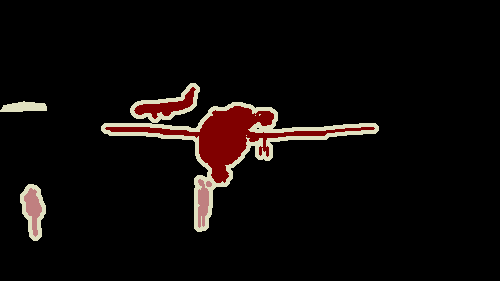

In [208]:
train_data.__getitem__(0)[1]

In [209]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

epochs = 5
train_losses = np.zeros(5)
for epoch in range(epochs):
    for inputs, targets in train_data:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
        
    train_losses[epoch] = loss
    print("Epoch {}/{}".format(epoch, epochs) + ": Loss is {}".format(train_losses[epoch]))